Based on:

* A deepsense.ai blog post [Keras vs. PyTorch - Alien vs. Predator recognition with transfer learning](https://deepsense.ai/keras-vs-pytorch-avp-transfer-learning) in which we compare and contrast Keras and PyTorch approaches.
* Repo with code: [github.com/deepsense-ai/Keras-PyTorch-AvP-transfer-learning](https://github.com/deepsense-ai/Keras-PyTorch-AvP-transfer-learning).
* https://github.com/pytorch/examples/blob/master/imagenet/main.py

Changes:

* Add densenet121
* Add imagenet preprocessing
* Add lr_scheduler

### 1. Import dependencies

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import time

In [2]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [3]:
torch.__version__  # should be 0.4.1

'0.4.1.post2'

In [4]:
import torchvision
torchvision.__version__  # should be 0.2.1

'0.2.1'

In [5]:
# Kaggle Kernel-dependent
input_path = "../input/alien_vs_predator_thumbnails/data/"

### 2. Create PyTorch data generators

In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Use resnet pre-processing
data_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(input_path + 'train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(input_path + 'validation', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}

### 3. Create the network

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
model = models.resnet50(pretrained=True).to(device)
# model = models.densenet121(pretrained=True).to(device)
# print(model)
for param in model.parameters():
    param.requires_grad = False   

# num_ftrs = model.classifier.in_features
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
# model.classifier = nn.Sequential(
#                nn.Linear(num_ftrs, 128),
#                nn.ReLU(inplace=True),
#                nn.Linear(128, 2)).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 88232618.29it/s]


In [9]:
criterion = nn.CrossEntropyLoss()
# Optimzer
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)
# LR scheduler
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                    cooldown=4,
                                                    verbose=True)

### 4. Train the model

In [10]:
def train_model(model, criterion, optimizer, num_epochs=3):
    last_end = time.time()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            epoch_time = time.time() - last_end
            last_end = time.time()
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            print('Epoch Time {epoch_time:.3f}'.format(epoch_time=epoch_time))
            if phase == 'validation':
                lr_scheduler.step(epoch_loss)
                print('-' * 10)
    return model

There is some error (even though the same version work on my own computer):

> RuntimeError: DataLoader worker (pid 56) is killed by signal: Bus error. Details are lost due to multiprocessing. Rerunning with num_workers=0 may give better error trace.
> RuntimeError: DataLoader worker (pid 59) exited unexpectedly with exit code 1. Details are lost due to multiprocessing. Rerunning with num_workers=0 may give better error trace.
 
See [this issue](https://github.com/pytorch/pytorch/issues/5301) and [that thread](https://discuss.pytorch.org/t/dataloader-randomly-crashes-after-few-epochs/20433/2). Setting `num_workers=0` in `DataLoader` solved it.

In [11]:
model_trained = train_model(model, criterion, optimizer, num_epochs=20)

Epoch 1/20
----------
train loss: 0.6380, acc: 0.6513
Epoch Time 4.738
validation loss: 0.5557, acc: 0.7500
Epoch Time 1.448
----------
Epoch 2/20
----------
train loss: 0.5290, acc: 0.7997
Epoch Time 3.434
validation loss: 0.4422, acc: 0.8300
Epoch Time 1.124
----------
Epoch 3/20
----------
train loss: 0.4514, acc: 0.8228
Epoch Time 3.507
validation loss: 0.3716, acc: 0.8900
Epoch Time 1.036
----------
Epoch 4/20
----------
train loss: 0.3993, acc: 0.8545
Epoch Time 3.300
validation loss: 0.3628, acc: 0.8850
Epoch Time 1.052
----------
Epoch 5/20
----------
train loss: 0.3693, acc: 0.8588
Epoch Time 3.374
validation loss: 0.3101, acc: 0.9150
Epoch Time 1.051
----------
Epoch 6/20
----------
train loss: 0.3175, acc: 0.8963
Epoch Time 3.339
validation loss: 0.2692, acc: 0.9300
Epoch Time 1.056
----------
Epoch 7/20
----------
train loss: 0.3245, acc: 0.8847
Epoch Time 3.313
validation loss: 0.2502, acc: 0.9250
Epoch Time 1.093
----------
Epoch 8/20
----------
train loss: 0.3256, acc: 0

### 5. Save and load the model

In [12]:
!mkdir models
!mkdir models/pytorch

In [13]:
torch.save(model_trained.state_dict(), 'models/pytorch/weights.h5')

In [14]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('models/pytorch/weights.h5'))

### 6. Make predictions on sample test images

In [15]:
validation_img_paths = ["validation/alien/11.jpg",
                        "validation/alien/22.jpg",
                        "validation/predator/33.jpg"]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

In [16]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [17]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[ 0.9233, -0.5076],
        [ 0.3597, -0.0823],
        [-1.1454,  1.1056]], device='cuda:0', grad_fn=<ThAddmmBackward>)

In [18]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[0.8070405 , 0.19295947],
       [0.60872954, 0.39127052],
       [0.09526707, 0.90473294]], dtype=float32)

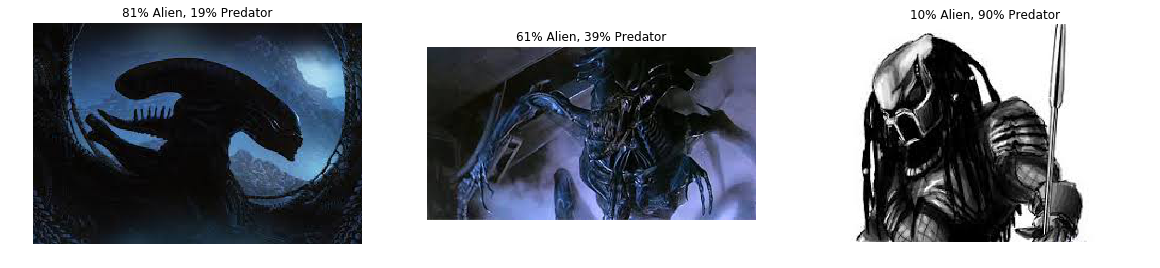

In [19]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)